In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Flatten, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

# Step 1: Frame Extraction from Videos
def extract_frames_from_videos(video_dir, output_dir, class_label, frame_rate=5):
    output_class_dir = os.path.join(output_dir, class_label)
    if not os.path.exists(output_class_dir):
        os.makedirs(output_class_dir)

    for video_file in os.listdir(video_dir):
        video_path = os.path.join(video_dir, video_file)
        video_capture = cv2.VideoCapture(video_path)
        success, frame = video_capture.read()
        count = 0
        frame_count = 0

        while success:
            if count % frame_rate == 0:
                frame_filename = os.path.join(output_class_dir, f"{video_file}frame{frame_count}.jpg")
                cv2.imwrite(frame_filename, frame)
                frame_count += 1
            success, frame = video_capture.read()
            count += 1

        video_capture.release()
        print(f"Extracted {frame_count} frames from {video_file}.")

# Directories for frames extraction
train_video_real_dir = '/kaggle/input/uadfv-dataset-new/fake_videos/train/real'
train_video_fake_dir = '/kaggle/input/uadfv-dataset-new/fake_videos/train/fake'
validation_video_real_dir = '/kaggle/input/uadfv-dataset-new/fake_videos/validation/real'
validation_video_fake_dir = '/kaggle/input/uadfv-dataset-new/fake_videos/validation/fake'

train_output_dir = 'extracted_frames/train'
validation_output_dir = 'extracted_frames/validation'

extract_frames_from_videos(train_video_real_dir, train_output_dir, 'real', frame_rate=5)
extract_frames_from_videos(train_video_fake_dir, train_output_dir, 'fake', frame_rate=5)
extract_frames_from_videos(validation_video_real_dir, validation_output_dir, 'real', frame_rate=5)
extract_frames_from_videos(validation_video_fake_dir, validation_output_dir, 'fake', frame_rate=5)

# Step 2: Define MesoNet4 with Dropout
def Meso4():
    input_layer = Input(shape=(224, 224, 3))
    x = Conv2D(8, (3, 3), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(16, (5, 5), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(32, (5, 5), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (5, 5), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Step 3: Load Pretrained ResNet50 Model and Adjust the Learning Rate
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_output = GlobalAveragePooling2D()(resnet.output)

# Step 4: Weighted Sum Layer
resnet_weight = tf.Variable(0.5, dtype=tf.float32, trainable=True, name='resnet_weight')
meso_weight = tf.Variable(0.5, dtype=tf.float32, trainable=True, name='meso_weight')

def weighted_sum(tensors):
    resnet_output, meso_output = tensors
    combined = resnet_weight * resnet_output + meso_weight * meso_output
    return combined

# Step 5: Build the Hybrid Model
def build_hybrid_model():
    input_layer = Input(shape=(224, 224, 3))
    resnet_features = resnet(input_layer)
    resnet_features = GlobalAveragePooling2D()(resnet_features)
    meso_net = Meso4()
    meso_features = meso_net(input_layer)
    combined_features = Lambda(weighted_sum)([resnet_features, meso_features])
    dense_1 = Dense(512, activation='relu')(combined_features)
    dense_1 = Dropout(0.5)(dense_1)
    output_layer = Dense(1, activation='sigmoid')(dense_1)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Step 6: Custom Callback to Monitor Weights
class WeightMonitorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: resnet_weight={resnet_weight.numpy()}, meso_weight={meso_weight.numpy()}")

# Step 7: Compile the Model
hybrid_model = build_hybrid_model()
hybrid_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Data Preprocessing and Combined Generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def combined_data_generator(img_dir, frame_dir, batch_size, target_size=(224, 224), subset="training"):
    image_generator = datagen.flow_from_directory(
        img_dir, 
        target_size=target_size, 
        batch_size=batch_size, 
        class_mode='binary',
        subset=subset
    )
    frame_generator = datagen.flow_from_directory(
        frame_dir, 
        target_size=target_size, 
        batch_size=batch_size, 
        class_mode='binary',
        subset=subset
    )
    
    while True:
        img_batch, img_labels = next(image_generator)
        frame_batch, frame_labels = next(frame_generator)
        combined_batch = np.concatenate([img_batch, frame_batch])
        combined_labels = np.concatenate([img_labels, frame_labels])
        yield combined_batch, combined_labels

train_img_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
validation_img_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
train_frame_dir = 'extracted_frames/train'
validation_frame_dir = 'extracted_frames/validation'

batch_size = 32
train_generator = combined_data_generator(train_img_dir, train_frame_dir, batch_size, subset='training')
validation_generator = combined_data_generator(validation_img_dir, validation_frame_dir, batch_size, subset='validation')

# Total sample counts for generator
def count_samples(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

total_train_images = int(0.2 * count_samples(train_img_dir))
total_train_frames = int(0.2 * count_samples(train_frame_dir))
total_val_images = int(0.2 * count_samples(validation_img_dir))
total_val_frames = int(0.2 * count_samples(validation_frame_dir))

steps_per_epoch = (total_train_images + total_train_frames) // batch_size
validation_steps = (total_val_images + total_val_frames) // batch_size

# Callbacks
checkpoint = ModelCheckpoint('/kaggle/working/epoch_{epoch:02d}_saved_model.keras', save_best_only=False, save_freq='epoch')
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)

# Step 9: Train Model
history = hybrid_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr, WeightMonitorCallback()]
)

# Save Final Model
hybrid_model.save('final_hybrid_model.keras')

# Step 11: Evaluate Model on Validation Set
def evaluate_model(generator, steps):
    y_true = []
    y_pred = []
    
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = hybrid_model.predict(x_batch)
        y_true.extend(y_batch)
        y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred).flatten()
    
    # Apply a threshold to get binary predictions
    y_pred_binary = (y_pred > 0.5).astype(int)

    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    auc = roc_auc_score(y_true, y_pred)

    return precision, recall, f1, auc

# Evaluate the model
precision, recall, f1, auc = evaluate_model(validation_generator, validation_steps)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')

# Step 12: Plotting Evaluation Metrics
def plot_evaluation_metrics(precision, recall, f1, auc):
    metrics = ['Precision', 'Recall', 'F1 Score', 'AUC']
    values = [precision, recall, f1, auc]

    plt.figure(figsize=(8, 4))
    plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Model Evaluation Metrics')
    plt.show()

plot_evaluation_metrics(precision, recall, f1, auc)


Extracted 57 frames from 0030.mp4.
Extracted 46 frames from 0023.mp4.
Extracted 69 frames from 0022.mp4.
Extracted 23 frames from 0020.mp4.
Extracted 27 frames from 0035.mp4.
Extracted 25 frames from 0038.mp4.
Extracted 41 frames from 0005.mp4.
Extracted 41 frames from 0014.mp4.
Extracted 34 frames from 0031.mp4.
Extracted 75 frames from 0013.mp4.
Extracted 42 frames from 0012.mp4.
Extracted 32 frames from 0007.mp4.
Extracted 46 frames from 0024.mp4.
Extracted 26 frames from 0016.mp4.
Extracted 59 frames from 0000.mp4.
Extracted 31 frames from 0034.mp4.
Extracted 37 frames from 0019.mp4.
Extracted 44 frames from 0015.mp4.
Extracted 22 frames from 0037.mp4.
Extracted 30 frames from 0003.mp4.
Extracted 28 frames from 0028.mp4.
Extracted 23 frames from 0017.mp4.
Extracted 205 frames from 0041.mp4.
Extracted 49 frames from 0002.mp4.
Extracted 24 frames from 0004.mp4.
Extracted 84 frames from 0011.mp4.
Extracted 48 frames from 0026.mp4.
Extracted 39 frames from 0027.mp4.
Extracted 91 frames

I0000 00:00:1730562821.326084     446 service.cc:145] XLA service 0x7a2e00003e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730562821.326152     446 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730562821.326156     446 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730562871.661787     446 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_34', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1730562871.726287     446 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/899 ━━━━━━━━━━━━━━━━━━━━ 11:39 875ms/step - accuracy: 0.7618 - loss: 0.4774

I0000 00:00:1730563001.458623     445 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_33', 20 bytes spill stores, 20 bytes spill loads



899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.9192 - loss: 0.1788Found 7885 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Epoch 1: resnet_weight=0.5, meso_weight=0.5
899/899 ━━━━━━━━━━━━━━━━━━━━ 1182s 1s/step - accuracy: 0.9193 - loss: 0.1787 - val_accuracy: 0.8886 - val_loss: 0.3007 - learning_rate: 1.0000e-04
Epoch 2/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.9751 - loss: 0.0616Epoch 2: resnet_weight=0.5, meso_weight=0.5
899/899 ━━━━━━━━━━━━━━━━━━━━ 1005s 1s/step - accuracy: 0.9751 - loss: 0.0616 - val_accuracy: 0.9420 - val_loss: 0.1422 - learning_rate: 1.0000e-04
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.9790 - loss: 0.0519Epoch 3: resnet_weight=0.5, meso_weight=0.5
899/899 ━━━━━━━━━━━━━━━━━━━━ 1002s 1s/step - accuracy: 0.9790 - loss: 0.0519 - val_accuracy: 0.9385 - val_loss: 0.1656 - learning_rate: 1.0000e-04
Epoch 4/10
803/899 ━━━━━━━━━━━━━━━━━━━━ 1:27 914ms/step - accuracy: 0.9807 - loss: 0.0484

I0000 00:00:1730566752.558851     447 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_34', 20 bytes spill stores, 20 bytes spill loads



899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.9807 - loss: 0.0482Epoch 4: resnet_weight=0.5, meso_weight=0.5
899/899 ━━━━━━━━━━━━━━━━━━━━ 1003s 1s/step - accuracy: 0.9807 - loss: 0.0482 - val_accuracy: 0.9587 - val_loss: 0.1276 - learning_rate: 1.0000e-04
Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9822 - loss: 0.0444Epoch 5: resnet_weight=0.5, meso_weight=0.5
899/899 ━━━━━━━━━━━━━━━━━━━━ 874s 972ms/step - accuracy: 0.9822 - loss: 0.0444 - val_accuracy: 0.9414 - val_loss: 0.1591 - learning_rate: 1.0000e-04
Epoch 6/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.9831 - loss: 0.0408Epoch 6: resnet_weight=0.5, meso_weight=0.5
899/899 ━━━━━━━━━━━━━━━━━━━━ 825s 918ms/step - accuracy: 0.9831 - loss: 0.0408 - val_accuracy: 0.9766 - val_loss: 0.0711 - learning_rate: 1.0000e-04
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.9844 - loss: 0.0391Epoch 7: resnet_weight=0.5, meso_weight=0.5
899/899 ━━━━━━━━━━━━━━━━━━━━ 722s 803ms/st

NameError: name 'precision_score' is not defined

In [3]:
# Import necessary metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(generator, steps):
    y_true = []
    y_pred = []
    
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        y_true.extend(y_batch)
        predictions = hybrid_model.predict(x_batch)
        y_pred.extend(predictions)

    # Convert lists to numpy arrays for easier handling
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply a threshold to get binary predictions
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate evaluation metrics
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    auc = roc_auc_score(y_true, y_pred)

    return precision, recall, f1, auc

# Evaluate the model
precision, recall, f1, auc = evaluate_model(validation_generator, validation_steps)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━

In [9]:
hybrid_model.save('/kaggle/working/model.keras')


In [7]:
import shutil

# Move the model file to the output directory
shutil.move('model.keras', '/kaggle/working/model.keras')


'/kaggle/working/model.keras'

In [8]:
import os

# Check if the file exists in the working directory
if os.path.exists('/kaggle/working/model.keras'):
    print("Model file exists and is ready for download.")
else:
    print("Model file not found.")


Model file exists and is ready for download.


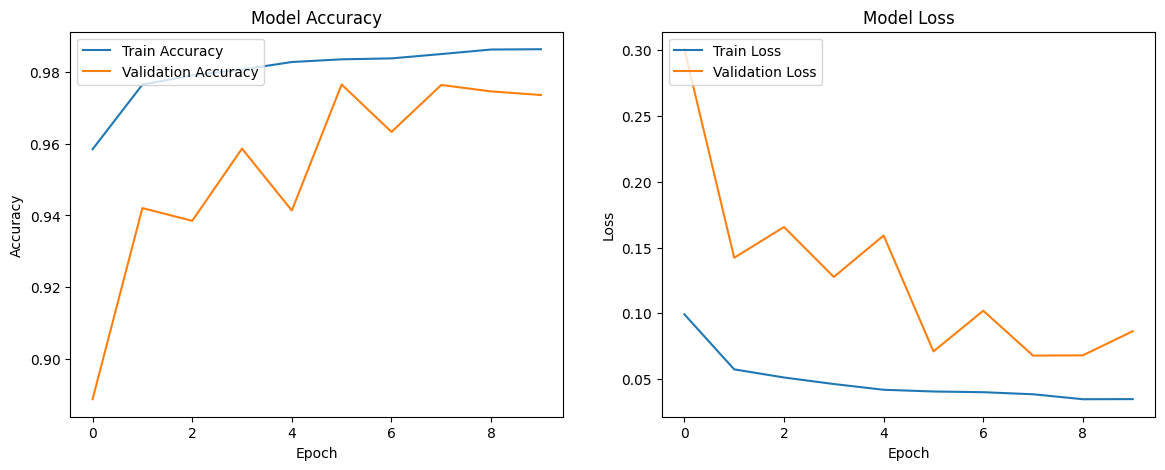

In [10]:
import matplotlib.pyplot as plt

# Assuming `history` is the result from model.fit()
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

# Call the function after training
plot_metrics(history)


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Call this function after getting y_true and y_pred
plot_confusion_matrix(y_true, y_pred_binary)


NameError: name 'y_true' is not defined

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

NameError: name 'y_true' is not defined

In [14]:
import shutil

# Move the model file to the output directory
shutil.move('model.keras', '/kaggle/working/model.keras')

# Now, you can create a link to download
download_link = '/kaggle/working/model.keras'
print(f'Download your model from this link: {download_link}')


Download your model from this link: /kaggle/working/model.keras


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━

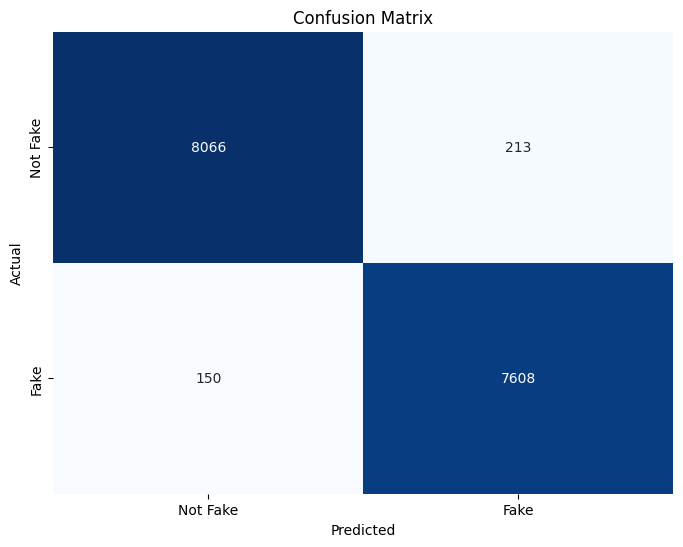

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to evaluate the model and get predictions
def get_predictions(generator, steps):
    y_true = []
    y_pred = []
    
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        y_true.extend(y_batch)
        predictions = hybrid_model.predict(x_batch)
        y_pred.extend(predictions)

    # Convert lists to numpy arrays for easier handling
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply a threshold to get binary predictions
    y_pred_binary = (y_pred > 0.5).astype(int)

    return y_true, y_pred_binary

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred_binary):
    cm = confusion_matrix(y_true, y_pred_binary)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Fake', 'Fake'], yticklabels=['Not Fake', 'Fake'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Get predictions from the model
y_true, y_pred_binary = get_predictions(validation_generator, validation_steps)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred_binary)


In [19]:
from IPython.display import FileLink

# Create a link to download the model
FileLink('/kaggle/working/model.keras')


/kaggle/working/model.keras

In [20]:
import os

In [21]:
# Create a directory for your model
os.makedirs('/kaggle/working/model', exist_ok=True)


In [22]:
# Save the model in the specified directory
hybrid_model.save('/kaggle/working/model/model.keras')


In [23]:
import os

# List files in the working directory
print(os.listdir('/kaggle/working/'))


['epoch_09_saved_model.keras', 'epoch_07_saved_model.keras', 'epoch_05_saved_model.keras', 'epoch_03_saved_model.keras', 'epoch_10_saved_model.keras', 'epoch_02_saved_model.keras', 'model.keras', 'epoch_08_saved_model.keras', 'epoch_06_saved_model.keras', 'epoch_04_saved_model.keras', '.virtual_documents', 'model', 'epoch_01_saved_model.keras', 'extracted_frames', 'final_hybrid_model.keras']


In [24]:
import shutil

# Move the model to the working directory if not already there
shutil.move('/kaggle/working/model.keras', '/kaggle/working/final_model.keras')

# Create a download link
from IPython.display import FileLink

# Generate a link to download the model
download_link = FileLink('/kaggle/working/final_model.keras')
download_link


/kaggle/working/final_model.keras

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up parameters
batch_size = 32
img_height, img_width = 224, 224  # Adjust to your model's input size

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]

# Create test data generator
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/deepfake-and-real-images/Dataset/Test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # Assuming binary classification
    shuffle=False  # Important to keep the order for evaluation
)


Found 10905 images belonging to 2 classes.


In [39]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Load the saved model
hybrid_model = tf.keras.models.load_model('/kaggle/working/final_hybrid_model.keras')

# Step 1: Frame Extraction for Test Videos
def extract_frames_from_test_videos(video_dir, output_dir, frame_rate=5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for video_file in os.listdir(video_dir):
        video_path = os.path.join(video_dir, video_file)
        video_capture = cv2.VideoCapture(video_path)
        success, frame = video_capture.read()
        frame_count = 0

        while success:
            if frame_count % frame_rate == 0:
                frame_filename = os.path.join(output_dir, f"{video_file}frame{frame_count}.jpg")
                cv2.imwrite(frame_filename, frame)
            success, frame = video_capture.read()
            frame_count += 1

        video_capture.release()
        print(f"Extracted frames from {video_file}.")

# Directories for test data
test_video_dir = '/kaggle/input/uadfv-dataset-new/fake_videos/test'  # Update this path
test_output_dir = 'extracted_frames/test'

extract_frames_from_test_videos(test_video_dir, test_output_dir, frame_rate=5)

# Step 2: Create a Test Data Generator
def test_data_generator(img_dir, frame_dir, batch_size, target_size=(224, 224)):
    image_generator = ImageDataGenerator(rescale=1.0 / 255.0).flow_from_directory(
        img_dir, 
        target_size=target_size, 
        batch_size=batch_size, 
        class_mode=None,  # No labels
        shuffle=False
    )
    
    frame_generator = ImageDataGenerator(rescale=1.0 / 255.0).flow_from_directory(
        frame_dir, 
        target_size=target_size, 
        batch_size=batch_size, 
        class_mode=None,  # No labels
        shuffle=False
    )
    
    while True:
        img_batch = next(image_generator)
        frame_batch = next(frame_generator)
        combined_batch = np.concatenate([img_batch, frame_batch])
        yield combined_batch

# Test directories for images and frames
test_img_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test'  # Update this path
test_frame_dir = 'extracted_frames/test'

# Create test generators
test_batch_size = 32
test_generator = test_data_generator(test_img_dir, test_frame_dir, test_batch_size)

# Calculate the number of steps for test evaluation
def count_samples(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

total_test_images = count_samples(test_img_dir)
total_test_frames = count_samples(test_frame_dir)

test_steps = (total_test_images + total_test_frames) // test_batch_size

# Step 3: Evaluate the Model on Test Data
def evaluate_model(generator, steps):
    y_true = []
    y_pred = []
    
    for _ in range(steps):
        x_batch = next(generator)
        preds = hybrid_model.predict(x_batch)
        y_pred.extend(preds)

    # Convert lists to numpy arrays for easier handling
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply a threshold to get binary predictions
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate evaluation metrics
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    auc = roc_auc_score(y_true, y_pred)

    return precision, recall, f1, auc

# Evaluate the model
precision, recall, f1, auc = evaluate_model(test_generator, test_steps)

print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test AUC: {auc:.4f}')

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=(['<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_2262>', '<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_2264>'],)
  • kwargs={'mask': ['None', 'None']}

In [42]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/kaggle/working/model/model.keras')



TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_5', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 2048], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'}, 'registered_name': None, 'name': 'input_layer_3', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_4'}, 'registered_name': None, 'name': 'input_layer_4', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_1', 'trainable': True, 'dtype': 'float32', 'function': <function weighted_sum at 0x7a2a50c6e170>, 'output_shape': [1], 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 2048], [None, 1]]}, 'name': 'lambda_1', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 2048], 'dtype': 'float32', 'keras_history': ['input_layer_3', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 1], 'dtype': 'float32', 'keras_history': ['input_layer_4', 0, 0]}}]], 'kwargs': {'mask': [None, None]}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_3', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1]}, 'name': 'dense_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1], 'dtype': 'float32', 'keras_history': ['lambda_1', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_3', 0, 0], ['input_layer_4', 0, 0]], 'output_layers': [['dense_3', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': 'adam', 'loss': 'binary_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Exception encountered when calling Lambda.call().

[1mcan only concatenate tuple (not "TrackedList") to tuple[0m

Arguments received by Lambda.call():
  • args=(['<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=input_layer_3>', '<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=input_layer_4>'],)
  • kwargs={'mask': ['None', 'None']}